In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary
from IPython.core.debugger import set_trace

from Tools import Trainer

## Loading datasets

In [2]:
from Tools.Dataloader import datasets_loader

normalize = torchvision.transforms.Normalize((0.4895832, 0.4546405, 0.41594946), 
                                (0.2520022, 0.24522494, 0.24728711))
train_val_transforms = torchvision.transforms.Compose([
                            torchvision.transforms.RandomCrop(64),
                            torchvision.transforms.RandomHorizontalFlip(),
                            torchvision.transforms.ToTensor(),
                            normalize])

norm_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                normalize])       
                                                  
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.FiveCrop(64), # this is a list of PIL Images
    torchvision.transforms.Lambda(lambda crops: torch.stack([norm_transforms(crop) for crop in crops])), # returns a 4D tensor
])
                                                  
train_loader, valid_loader, test_loader = datasets_loader(train_val_transforms, test_transforms)

## Hyper-parameters

In [3]:
hyperparams = {'num_epochs': 60,
               'lr0' :0.1, 
               'dropout':0.25,
               'gamma': 1,
               'adjust_lr': False,
               'init_weights':True,
               'save_checkpoint': True      
                  }
cuda_available = torch.cuda.is_available()

## Creating the model

In [4]:
from Classifier.VGG import VGG16_Dropout

model = VGG16_Dropout(hyperparams)
if cuda_available:
    model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams['lr0'])
criterion = nn.CrossEntropyLoss()

In [5]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
   GaussianDropout-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
              ReLU-5           [-1, 64, 64, 64]               0
   GaussianDropout-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
              ReLU-9          [-1, 128, 32, 32]               0
  GaussianDropout-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
             ReLU-12          [-1, 128, 32, 32]               0
        MaxPool2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## Training 

In [6]:
from Tools.Trainer import Trainer

trainer = Trainer(model, optimizer, criterion, train_loader, valid_loader, test_loader, hyperparams)
nll_train, nll_valid, acc_train, acc_valid =  trainer.train_model()
print('Done...')

------ Epoch # 1 ------
 Iteration 40: TRAIN 0.6935
 Iteration 80: TRAIN 0.6932
 Iteration 120: TRAIN 0.6934
 [Loss] TRAIN 0.6938 / VALID 0.6945
 [ACC] TRAIN 0.5004 / VALID 0.4915
new checkpoint is saved!
------ Epoch # 2 ------
 Iteration 160: TRAIN 0.6935
 Iteration 200: TRAIN 0.6933
 Iteration 240: TRAIN 0.6931
 Iteration 280: TRAIN 0.6929
 [Loss] TRAIN 0.6946 / VALID 0.6957
 [ACC] TRAIN 0.5004 / VALID 0.4915
new checkpoint is saved!
------ Epoch # 3 ------
 Iteration 320: TRAIN 0.6923
 Iteration 360: TRAIN 0.6923
 Iteration 400: TRAIN 0.6917
 Iteration 440: TRAIN 0.6905
 [Loss] TRAIN 0.6896 / VALID 0.6872
 [ACC] TRAIN 0.5309 / VALID 0.5576
new checkpoint is saved!
------ Epoch # 4 ------
 Iteration 480: TRAIN 0.6888
 Iteration 520: TRAIN 0.6902
 Iteration 560: TRAIN 0.6852
 [Loss] TRAIN 0.6802 / VALID 0.6745
 [ACC] TRAIN 0.5760 / VALID 0.5836
new checkpoint is saved!
------ Epoch # 5 ------
 Iteration 600: TRAIN 0.6871
 Iteration 640: TRAIN 0.6812
 Iteration 680: TRAIN 0.6838
 Iter

 Iteration 5360: TRAIN 0.1181
 [Loss] TRAIN 0.1331 / VALID 0.3242
 [ACC] TRAIN 0.9474 / VALID 0.8789
new checkpoint is saved!
------ Epoch # 37 ------
 Iteration 5400: TRAIN 0.1219
 Iteration 5440: TRAIN 0.1241
 Iteration 5480: TRAIN 0.1258
 [Loss] TRAIN 0.1023 / VALID 0.3167
 [ACC] TRAIN 0.9591 / VALID 0.8809
new checkpoint is saved!
------ Epoch # 38 ------
 Iteration 5520: TRAIN 0.1274
 Iteration 5560: TRAIN 0.1097
 Iteration 5600: TRAIN 0.1111
 Iteration 5640: TRAIN 0.1134
 [Loss] TRAIN 0.1311 / VALID 0.3092
 [ACC] TRAIN 0.9476 / VALID 0.8689
new checkpoint is saved!
------ Epoch # 39 ------
 Iteration 5680: TRAIN 0.1001
 Iteration 5720: TRAIN 0.1586
 Iteration 5760: TRAIN 0.0955
 Iteration 5800: TRAIN 0.1016
 [Loss] TRAIN 0.0936 / VALID 0.3526
 [ACC] TRAIN 0.9641 / VALID 0.8929
new checkpoint is saved!
------ Epoch # 40 ------
 Iteration 5840: TRAIN 0.0903
 Iteration 5880: TRAIN 0.1037
 Iteration 5920: TRAIN 0.1003
 Iteration 5960: TRAIN 0.0852
 [Loss] TRAIN 0.1520 / VALID 0.4593


## Visualization

### accuracy and loss plots

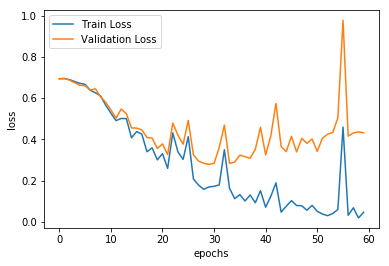

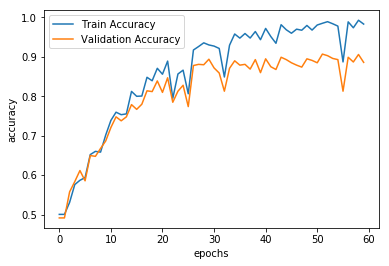

In [7]:
import Tools.Visualization as V
V.plots(nll_train, nll_valid, acc_train, acc_valid)

In [8]:
print(len(nll_train))

60


In [16]:
import torchviz
from torch.autograd import Variable
def draw_computational_graph(model):
    x = Variable(torch.randn(1,3,64,64))
    if torch.cuda.is_available():
        x = x.cuda()
    y = model(x)
    img = torchviz.make_dot(y.mean(), params=dict(model.named_parameters()))
    img.format = 'png'
    img.render()
    print('Done...')

In [17]:
draw_computational_graph(model)

Done...


### Confusion Matrix

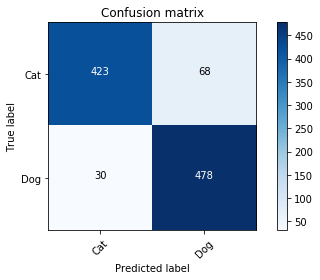

In [18]:
import Tools.Visualization as V
cnf_matrix = trainer.confusion_matrix()
V.plot_confusion_matrix(cnf_matrix)

## Saving the model

In [21]:
torch.save(model, "./Experiments/VGG-Dropout(Strong)-Augmented-5crop")

## Generate Submission

In [20]:
import Tools.Trainer as T
results = T.predict_test_set_5crop(model, test_loader)
# print(results.size())
T.generate_submission(results)

Done...


In [ ]:
mode